In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler



In [36]:
data_path="../data/predictive-maintenance/CMaps/"
# -------------------------------
# 1. Load FD001 data
# -------------------------------
train_file = data_path+"train_FD001.txt"
test_file = data_path+"test_FD001.txt"
rul_file = data_path+"RUL_FD001.txt"

# According to NASA docs: 26 columns = id, cycle, 3 op settings, 21 sensors
col_names = ['engine_id', 'cycle', 'os1', 'os2', 'os3'] + [f'sensor{i}' for i in range(1, 22)]

train = pd.read_csv(train_file, sep=" ", header=None)
train.dropna(axis=1, how='all', inplace=True)  # remove empty cols from spacing
train.columns = col_names

test = pd.read_csv(test_file, sep=" ", header=None)
test.dropna(axis=1, how='all', inplace=True)
test.columns = col_names

rul = pd.read_csv(rul_file, sep=" ", header=None)
rul.dropna(axis=1, how='all', inplace=True)
rul.columns = ["RUL"]

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("RUL shape:", rul.shape)

# -------------------------------
# 2. Compute RUL for training set
# -------------------------------
rul_train = train.groupby("engine_id")['cycle'].max().reset_index()
rul_train.columns = ["engine_id", "max_cycle"]

train = train.merge(rul_train, on="engine_id", how="left")
train["RUL"] = train["max_cycle"] - train["cycle"]
train.drop("max_cycle", axis=1, inplace=True)

train.head()

Train shape: (20631, 26)
Test shape: (13096, 26)
RUL shape: (100, 1)


,engine_id,cycle,os1,os2,os3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


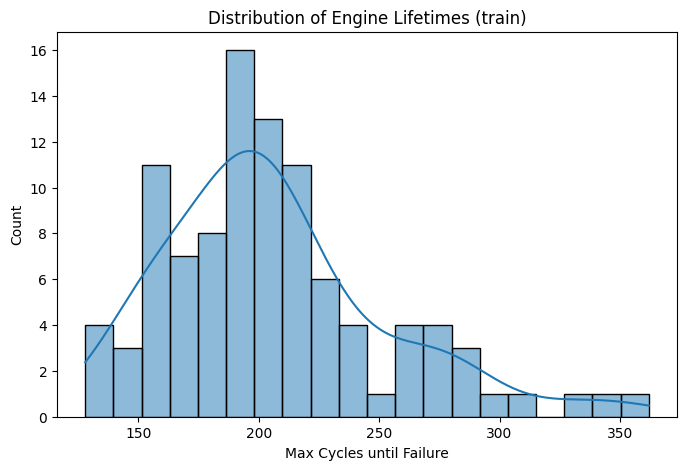

In [25]:
# -------------------------------
# 3. Basic EDA
# -------------------------------

# a) Distribution of engine lifetimes
plt.figure(figsize=(8,5))
sns.histplot(rul_train["max_cycle"], bins=20, kde=True)
plt.title("Distribution of Engine Lifetimes (train)")
plt.xlabel("Max Cycles until Failure")
plt.ylabel("Count")
plt.show()

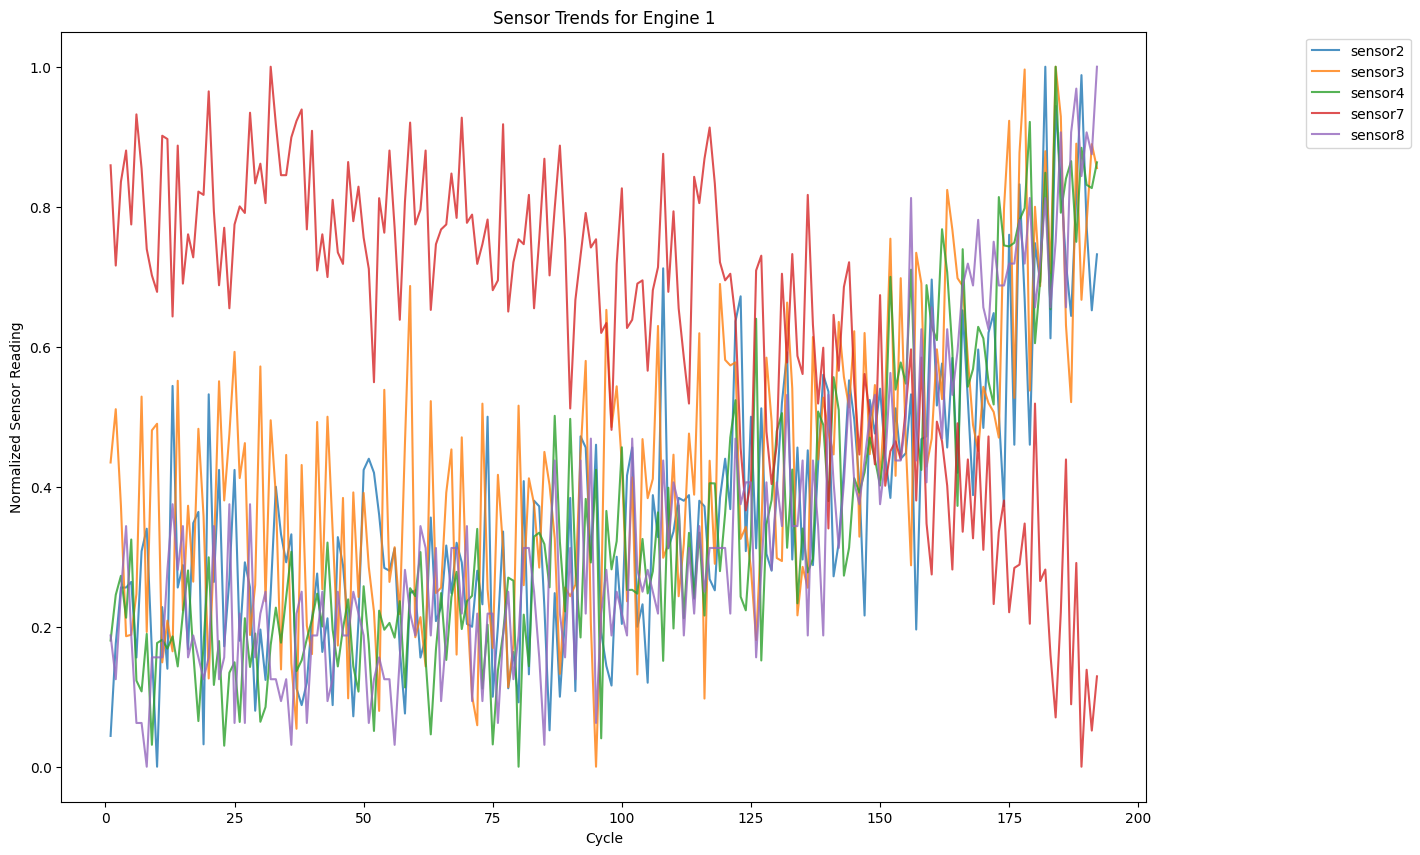

In [42]:
engine_id_to_plot = 1
engine_df = train[train["engine_id"] == engine_id_to_plot].copy()

# list of sensors 
useful_sensors = [
    'sensor2','sensor3','sensor4','sensor7','sensor8',
]

# normalize each sensor individually for plotting
engine_norm = engine_df.copy()
for s in useful_sensors:
    vals = engine_df[s]
    engine_norm[s] = (vals - vals.min()) / (vals.max() - vals.min())

# plot all useful sensors
plt.figure(figsize=(14,10))
for s in useful_sensors:
    plt.plot(engine_norm["cycle"], engine_norm[s], label=s, alpha=0.8)

plt.xlabel("Cycle")
plt.ylabel("Normalized Sensor Reading")
plt.title(f"Sensor Trends for Engine {engine_id_to_plot}")
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
plt.show()

In [43]:
# -------------------------------
# 4. Preprocessing (Scaling + Feature Selection)
# -------------------------------

# Some sensors are constant → remove low-variance ones
var = train.var()
low_var = var[var < 1e-5].index
print("Dropped low-variance sensors:", list(low_var))

features = [c for c in train.columns if c not in ["id","cycle","RUL"] and c not in low_var]

scaler = MinMaxScaler()
train_scaled = train.copy()
train_scaled[features] = scaler.fit_transform(train_scaled[features])

print("Final features used:", features)

Dropped low-variance sensors: ['os1', 'os2', 'os3', 'sensor1', 'sensor5', 'sensor6', 'sensor10', 'sensor16', 'sensor18', 'sensor19']
Final features used: ['engine_id', 'sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8', 'sensor9', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor17', 'sensor20', 'sensor21']


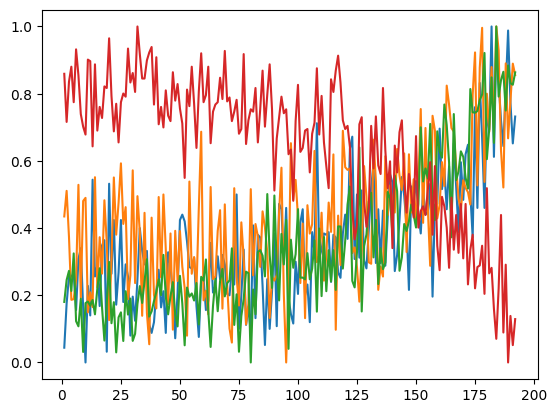

In [39]:
engine1 = train[train["engine_id"] == 1]
for s in ["sensor2", "sensor3", "sensor4", "sensor7"]:
    vals = engine1[s]
    norm = (vals - vals.min()) / (vals.max() - vals.min())  # normalize
    plt.plot(engine1["cycle"], norm, label=s)
